# 14. 폐렴아 기다려라!

## 6. 프로젝트 : 폐렴 진단기 성능개선
대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야할 것이다.

그렇다면 좀전까지의 과정을 되짚어보면서, 어떤 점을 좀 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 한다.

__바꿀 수 있는 것들__

* 이미지 크기
* BATCH_SIZE
* EPOCH
* 채널 개수
* 모델 구조
* BatchNorm 유무
* Dropout 유무 or 비율 변경

### Step 1. 실험환경 Set-up
---
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것이다.

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


앞으로 필요한 변수들을 생성한다.

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'AIFFEL/Exploration/E14_xray/chest_xray/chest_xray')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 20

print(ROOT_PATH)

/home/aiffel-dj10/AIFFEL/Exploration/E14_xray/chest_xray/chest_xray


### Step 2. 데이터 준비하기
---
원본 데이터를 가져와서 전처리 및 배치 구성을 진행한다.<br>
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않다. 이를 극복할 수 있는 방법을 고민해보자.

augmentation 기법을 고려해 볼 수 있을 것이다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수는 없다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다.<br>
그래서 augmentation 도입은 신중해야 한다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것이다.

```bash
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
```

In [4]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있다.

갯수 비는 89%, 10.7%, 0.3% 이다. val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하자.

In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었다. test_size를 수정하면 갯수는 달라질 수 있다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보자.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다. 오늘 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 한다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정이다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없다.

tf.data 인스턴스를 만들어보자. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터 셋, validation 데이터 셋 갯수 확인을 해보자.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


라벨 이름들을 한번 확인해보자.

In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


두 개의 라벨이 있다. 정상을 의미하는 'NORMAL', 폐렴을 의미하는 'PNEUMONIA' 가 있다.

현재 이미지에는 라벨 데이터가 따로 없다. 제목에 'NORMAL', 'PNEUMONIA'라고 되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어야한다.

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.<br>
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자.<br>
decode_img 함수와 process_path 함수를 만들겠다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다. get_label을 이용해서 라벨 값을 가져온다.

In [11]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해준다.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해보자.

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가있는 모습이다. 참고로, 코드에서 `train_ds.take(1)`은 하나의 데이터만 가져온다 라는 의미이다.

위에서 train과 validation 데이터 셋을 만든 것 처럼 test 데이터 셋도 만들어 보겠다. 그리고 데이터 갯수도 확인해보자.

In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.<br>
밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜준다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.

repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해준다.<br>
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.<br>
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.

prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화
---
학습용 데이터를 시각화해서 확인해본다.<br>
만약 augmentation을 시도했다면 `show_batch()` 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해보자.

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출한다. 추출된 배치를 image와 label 데이터 셋으로 나눈다. 이제 show_batch()함수를 이용해서 결과 사진을 보겠다.

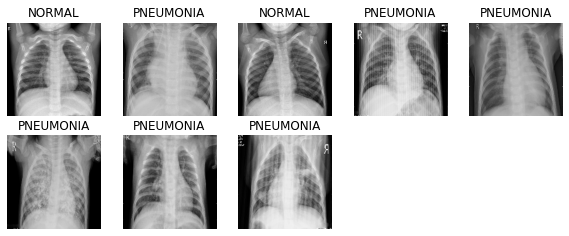

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링
---
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있다.

그리고, BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 사용했다.<br>
이것은 일반적으로 잘 사용되는 형태는 아니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해보자. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있다. 또, Dropout 비율을 변경해볼 수도 있다.

가장 대표적인 딥러닝 모델인 CNN을 모델링하고 결과를 만들어 보겠다.

[CNN, Convolutional Neural Network 요약](http://taewan.kim/post/cnn/)

먼저, Convolution block을 만든다. conv_block()의 구성은 Convolution을 두번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다. 그리고 Max Pooling을 한다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

Dense Block은 아래와 같이 만든다.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델이다. 전형적인 CNN 모델과는 약간 다른 모델이다.

어떤 부분이 가장 특이한가? 눈에 띄었을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두가지 regularization 기법이 동시에 사용되고 있다.<br>
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다. 대표적으로 아래와 같은 논문의 사례를 들 수 있다.

* [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발시키는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다. 예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있다.

* [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

두가지를 함께 사용하는 이 모델이 성능향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분이다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
---
데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 `class_weight`를 설정해 주었다. 만약 이러한 처리를 생략한다면 어떻게 될까? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까?

위에서 얘기 했던 데이터 imbalance 문제이다.<br>
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었다. 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.

이런 문제들을 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용된다. Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다. 상세한 내용은 아래 링크 참고.

* [딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 `weight_for_0`은 'Normal' 이미지에 사용할 weight를, `weight_for_1`은 'Pneumonia' 이미지에 사용할 weight를 세팅한다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다.

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


### Step 6. 모델 훈련
---
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것이다.

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용한다. optimizer로 'adam'을 사용한다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보자. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어준다.

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 27s 105ms/step - loss: 0.4544 - accuracy: 0.7617 - precision: 0.9339 - recall: 0.7302 - val_loss: 0.8128 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 23s 87ms/step - loss: 0.2392 - accuracy: 0.9037 - precision: 0.9716 - recall: 0.8962 - val_loss: 1.7173 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 23s 87ms/step - loss: 0.2022 - accuracy: 0.9236 - precision: 0.9740 - recall: 0.9215 - val_loss: 0.5373 - val_accuracy: 0.7798 - val_precision: 0.7724 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 23s 87ms/step - loss: 0.2008 - accuracy: 0.9219 - precision: 0.9770 - recall: 0.9166 - val_loss: 0.2027 - val_accuracy: 0.9125 - val_precision: 0.8971 - val_recall: 0.9974
Epoch 5/20
261/261 [==============================] - 23s 86ms/step - loss: 0.1743 - accuracy: 

### Step 7. 결과 확인과 시각화
---
테스트데이터로 훈련된 모델을 평가해보자. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요하다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 하자.

이제 결과를 확인해보자. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다.

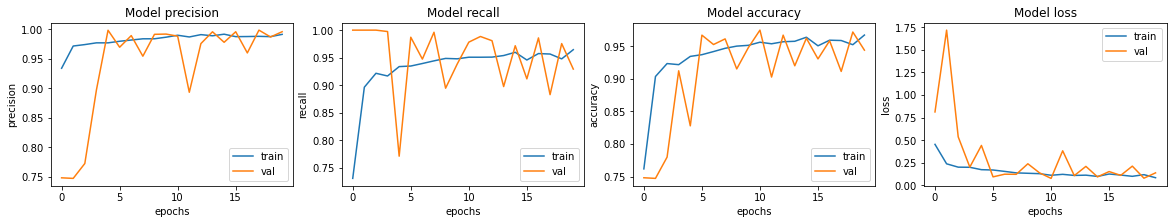

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 해보겠다.

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.4965 - accuracy: 0.8686 - precision: 0.8468 - recall: 0.9641


### 회고
---
* 처음에 아무것도 바꾸지 않고 모델을 학습시켜보았다. 정확도가 0.7420 나왔다.
* 영석님이 이미지 크기를 늘려보라고 해서 (500, 500)으로 시도해보았지만 역시나 정확도가 좋게 나오지 않았다.
* 모델을 좀 변경해야 할 것 같아서, BatchNormalization을 추가하고 정확도가 0.8이 나왔다. 정확도가 큰폭으로 상승한 걸 보고BatchNormalization은 필요하다고 판단했다.
* 그래서 이번에는 dropout을 제거해보았다. 그랬더니 정확도가 0.8325 정도 나오는 것을 확인했다.  
* 조금 더 정확도를 올려야 하기에 데이터의 부족함을 매울수 있는 좌우반전 augmentation을 시도해서 부족한 데이터를 만들었다.
* 그렇게 정확도를 0.8686에 맞출 수 있었다.
<br><br>
* __성능 향상을 위해 변경한 것들__
    - 이미지 크기는 (180, 180), BATCH_SIZE = 16, EPOCHS = 20으로 큰 변경없이 진행했다.
    - imbalance를 극복하기 위해 train 데이터와 validation 데이터에 좌우반전 augmentation을 진행하였다. 
    - 학습 모델에서는 dropout을 없애고 BatchNormalization을 추가했다.
    - 그래서 기존 모델 conv_block(32), conv_block(64), conv_block(128), dropout(0.2), conv_block(256), dropout(0.2) 에서
        - conv_block(32), conv_block(64), conv_block(128), __BatchNorm()__, conv_block(256), __BatchNorm()__ 구조로 설계했다.
     

### 루브릭
---
* 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.<br>
(_모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다._)

    * __모델 loss가 초반에는 튀었지만 뒤로 갈수록 점점 0에 수렴하였다.__

* 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.<br>
( _regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다._)
    
    * __데이터 준비, 모델구성 변경 한것들을 회고 아래에 상세하게 적었다.__

* 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.<br>
(_Accuracy 기준 85%에 도달하였다._)
    
    * __Accuracy 기준 0.8686에 도달하였다.__